# DTSA 5509 Final Project

## Introduction

In this notebook you can find an example of a regression problem and its solution using sklearn library.

As a datasource we are using [Azure Open Datasets](https://learn.microsoft.com/en-us/azure/open-datasets/dataset-catalog) that are provided by Microsoft alongside with Python API to donwload needed data slices. In order to use the datasets no registration is required. Thanks to that we should not host data in the repository. The notebook is using slices from two datasets: [NYC Yellow Taxi trip records](https://learn.microsoft.com/en-us/azure/open-datasets/dataset-taxi-yellow?tabs=azureml-opendatasets) and [NYC Green Taxi trip records](https://learn.microsoft.com/en-us/azure/open-datasets/dataset-taxi-green?tabs=azureml-opendatasets). Both datasets are very similar and can be merged after some data preprocessing steps.

Our problem, that we are solving in this notebook, is to estimate a trip fare. If we get a very accurate model, it will be possible to use it in any mobile application that help people to find the most optimal/cheap transportation route. It's exactly the reason why we are using both yellow and green taxi providers to estimate the fare.

The following cell contains all the modules that we are using in this notebook. In fact, just 4 packages should be installed to make all modules available:

```
azureml-opendatasets
matplotlib
seaborn
scikit-learn
```

In [1]:
from azureml.opendatasets import NycTlcGreen, NycTlcYellow
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.neural_network import MLPRegressor
from sklearn import tree, svm
from sklearn.ensemble import GradientBoostingRegressor

## Step 1. Download data

The datasets are very big, and a Spark engine may be required to do all needed calculations. That's why, we are building a model for a single month only (January), downloading this slice only and limit the number of records to 10 thousands from each dataset.

In [2]:
green_taxi_df = pd.DataFrame([])

# timeframe that we are picing as an example
start = datetime.strptime("1/1/2016","%m/%d/%Y")
end = datetime.strptime("1/31/2016","%m/%d/%Y")

green_taxi_df = NycTlcGreen(start, end).to_pandas_dataframe()

# number of samples to take
green_taxi_df = green_taxi_df.sample(10000)

[Info] read from /var/folders/23/9mlldg893ms3d5sk6kqm5z_40000gn/T/tmp4wqhyf3l/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=1/part-00119-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2689-1.c000.snappy.parquet


In [3]:
yellow_taxi_df = pd.DataFrame([])

# timeframe that we are picing as an example
start = datetime.strptime("1/1/2016","%m/%d/%Y")
end = datetime.strptime("1/31/2016","%m/%d/%Y")

yellow_taxi_df = NycTlcYellow(start, end).to_pandas_dataframe()

# number of samples to take
yellow_taxi_df = yellow_taxi_df.sample(10000)

[Info] read from /var/folders/23/9mlldg893ms3d5sk6kqm5z_40000gn/T/tmpu8kzfhw6/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2016/puMonth=1/part-00000-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426339-90.c000.snappy.parquet
[Info] read from /var/folders/23/9mlldg893ms3d5sk6kqm5z_40000gn/T/tmpu8kzfhw6/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2016/puMonth=1/part-00016-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426328-88.c000.snappy.parquet
[Info] read from /var/folders/23/9mlldg893ms3d5sk6kqm5z_40000gn/T/tmpu8kzfhw6/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2016/puMonth=1/part-00001-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426336-89.c000.snappy.parquet
[Info] read from /var/folders/23/9mlldg893ms3d5sk6kqm5z_40000gn/T/tmpu8kzfhw6/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2016/puMonth=1/part-00017-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4

Print basic statistic about numeric columns. It should help us to locate columns with the highest deviation that can be a good first step to locate anomalies. For example, from the table below we can see that longtitude for pick up and drop off locations are taking 0 for some examples that is not possible to reach for a NYC taxi:) Additionally, some fares are negative - it's hard to see a situation when a taxi driver pays you for a trip.

In [4]:
green_taxi_df.describe()

,vendorID,passengerCount,tripDistance,pickupLongitude,pickupLatitude,dropoffLongitude,dropoffLatitude,rateCodeID,paymentType,fareAmount,extra,mtaTax,tipAmount,tollsAmount,ehailFee,totalAmount,tripType
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,0.0,10000.000000,10000.000000
mean,1.783900,1.360500,2.770590,-73.733464,40.631788,-73.798465,40.666627,1.098500,1.513500,12.05135,0.351100,0.486400,1.269567,0.097187,NaN,14.547135,1.023000
std,0.411604,1.023936,2.888061,3.929209,2.154424,3.246668,1.775941,0.607647,0.523493,11.81415,0.372347,0.090088,3.451067,0.769471,NaN,13.631516,0.149911
min,1.000000,0.000000,0.000000,-115.173744,0.000000,-115.143494,0.000000,1.000000,1.000000,-60.00000,-1.000000,-0.500000,-5.000000,0.000000,NaN,-65.000000,1.000000
25%,2.000000,1.000000,1.010000,-73.960365,40.693426,-73.967602,40.694237,1.000000,1.000000,6.00000,0.000000,0.500000,0.000000,0.000000,NaN,7.800000,1.000000
50%,2.000000,1.000000,1.800000,-73.946529,40.745821,-73.945152,40.745787,1.000000,2.000000,9.00000,0.500000,0.500000,0.000000,0.000000,NaN,11.160000,1.000000
75%,2.000000,1.000000,3.440000,-73.917755,40.800550,-73.910530,40.788481,1.000000,2.000000,14.50000,0.500000,0.500000,2.000000,0.000000,NaN,17.300000,1.000000
max,2.000000,6.000000,41.100000,0.000000,40.903889,0.000000,41.012783,5.000000,5.000000,499.00000,1.000000,3.000000,250.000000,12.500000,NaN,499.000000,2.000000


Print few rows from each set to see the nature of data.

In [5]:
green_taxi_df.head(10)

,vendorID,lpepPickupDatetime,lpepDropoffDatetime,passengerCount,tripDistance,puLocationId,doLocationId,pickupLongitude,pickupLatitude,dropoffLongitude,...,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,tollsAmount,ehailFee,totalAmount,tripType
742341,2,2016-01-09 21:17:14,2016-01-09 21:31:18,1,7.74,None,None,-73.962029,40.715984,-73.976669,...,2,22.5,0.5,0.5,0.3,0.00,0.0,NaN,23.80,1.0
6046,2,2016-01-01 21:24:19,2016-01-01 21:40:52,1,3.84,None,None,-73.946091,40.807102,-73.963226,...,1,15.0,0.5,0.5,0.3,3.26,0.0,NaN,19.56,1.0
74678,2,2016-01-06 13:34:14,2016-01-06 13:48:25,6,5.99,None,None,-73.800514,40.703194,-73.782097,...,1,19.0,0.0,0.5,0.3,3.96,0.0,NaN,23.76,1.0
1009457,2,2016-01-21 18:11:30,2016-01-21 18:18:10,1,1.43,None,None,-73.871201,40.734097,-73.893471,...,2,7.0,1.0,0.5,0.3,0.00,0.0,NaN,8.80,1.0
456487,2,2016-01-08 15:11:11,2016-01-08 15:31:54,3,2.86,None,None,-73.964935,40.806732,-73.952667,...,2,15.0,0.0,0.5,0.3,0.00,0.0,NaN,15.80,1.0
1190069,2,2016-01-13 13:13:04,2016-01-13 13:22:01,1,1.54,None,None,-73.937912,40.803787,-73.945908,...,1,7.5,0.0,0.5,0.3,1.00,0.0,NaN,9.30,1.0
1352930,2,2016-01-06 20:07:20,2016-01-06 20:13:43,1,1.13,None,None,-73.903358,40.745880,-73.900352,...,1,6.5,0.5,0.5,0.3,1.56,0.0,NaN,9.36,1.0
526338,2,2016-01-11 22:40:39,2016-01-11 22:43:59,1,0.93,None,None,-73.991882,40.680847,-73.990875,...,1,5.0,0.5,0.5,0.3,0.00,0.0,NaN,6.30,1.0
281884,1,2016-01-22 10:11:32,2016-01-22 10:16:09,1,1.50,None,None,-73.949226,40.785248,-73.936462,...,1,6.0,0.0,0.5,0.3,1.35,0.0,NaN,8.15,1.0
959096,1,2016-01-16 02:31:47,2016-01-16 02:36:10,2,0.60,None,None,-73.951218,40.716808,-73.951202,...,1,5.0,0.5,0.5,0.3,1.25,0.0,NaN,7.55,1.0


In [6]:
yellow_taxi_df.describe()

,passengerCount,tripDistance,startLon,startLat,endLon,endLat,rateCodeId,fareAmount,extra,mtaTax,tipAmount,tollsAmount,totalAmount
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.675800,2.908236,-72.796263,40.103055,-72.878461,40.149277,1.034900,12.488377,0.315350,0.498150,1.775784,0.298251,15.675762
std,1.342116,3.618572,9.253664,5.097825,8.932911,4.921269,0.255907,10.984383,0.366323,0.031172,2.449633,1.383009,13.491677
min,1.000000,0.000000,-74.318916,0.000000,-74.318962,0.000000,1.000000,-6.500000,-0.500000,-0.500000,0.000000,0.000000,-7.800000
25%,1.000000,1.000000,-73.991465,40.736229,-73.991350,40.735488,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,8.300000
50%,1.000000,1.670000,-73.981300,40.753632,-73.979424,40.754776,1.000000,9.000000,0.000000,0.500000,1.350000,0.000000,11.620000
75%,2.000000,3.040000,-73.965637,40.768434,-73.961193,40.770023,1.000000,14.000000,0.500000,0.500000,2.300000,0.000000,17.160000
max,6.000000,28.600000,0.000000,40.910587,0.000000,40.944138,5.000000,299.000000,1.000000,0.500000,49.800000,23.580000,299.300000


In [7]:
yellow_taxi_df.head(10)

,vendorID,tpepPickupDateTime,tpepDropoffDateTime,passengerCount,tripDistance,puLocationId,doLocationId,startLon,startLat,endLon,...,rateCodeId,storeAndFwdFlag,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,tollsAmount,totalAmount
210315,1,2016-01-21 14:44:49,2016-01-21 14:49:25,1,0.90,None,None,-73.969429,40.785599,-73.960686,...,1,N,2,5.5,0.0,0.5,0.3,0.00,0.0,6.30
318103,1,2016-01-07 18:10:57,2016-01-07 18:40:49,1,3.20,None,None,-73.997383,40.720779,-73.990623,...,1,N,1,19.0,1.0,0.5,0.3,4.15,0.0,24.95
285861,1,2016-01-04 15:11:59,2016-01-04 15:16:54,1,0.80,None,None,-73.973900,40.791416,-73.980110,...,1,N,2,5.5,0.0,0.5,0.3,0.00,0.0,6.30
286064,2,2016-01-15 16:03:47,2016-01-15 16:07:32,1,0.90,None,None,-73.988548,40.759029,-73.978905,...,1,N,1,5.0,1.0,0.5,0.3,1.70,0.0,8.50
487891,2,2016-01-03 19:03:48,2016-01-03 19:17:46,1,2.27,None,None,-73.982132,40.742821,-73.999863,...,1,N,1,11.0,0.0,0.5,0.3,2.00,0.0,13.80
170993,1,2016-01-19 21:27:05,2016-01-19 21:32:13,1,0.90,None,None,-73.982254,40.765556,-73.992073,...,1,N,1,5.5,0.5,0.5,0.3,1.36,0.0,8.16
47304,2,2016-01-18 13:32:58,2016-01-18 13:40:02,1,1.16,None,None,-73.991554,40.739262,-74.005829,...,1,N,1,6.5,0.0,0.5,0.3,1.46,0.0,8.76
459866,2,2016-01-01 20:02:05,2016-01-01 20:10:07,1,1.71,None,None,0.000000,0.000000,0.000000,...,1,N,2,8.0,0.5,0.5,0.3,0.00,0.0,9.30
473785,1,2016-01-29 17:27:50,2016-01-29 17:31:23,1,0.80,None,None,-73.978851,40.740620,-73.986641,...,1,N,2,5.0,1.0,0.5,0.3,0.00,0.0,6.80
516843,1,2016-01-28 17:29:33,2016-01-28 17:37:14,1,1.10,None,None,-73.971626,40.766068,-73.958267,...,1,N,1,7.0,1.0,0.5,0.3,2.60,0.0,11.40


## Step 2. Data cleansing

Let's start data cleaning with columns that have None values based on out initial observations.
We will print a list of unique values for `puLocationId` and `doLocationId` columns.

In [8]:
green_taxi_df['puLocationId'].unique()

array([None], dtype=object)

In [9]:
green_taxi_df['doLocationId'].unique()

array([None], dtype=object)

Looks like that both columns (at least in NYC Green) contain None values only. So, we will delete these columns from both datasets.

Additionally, print lists of columns for both datasets and see if we can map them

In [10]:
green_taxi_df.columns

Index(['vendorID', 'lpepPickupDatetime', 'lpepDropoffDatetime',
       'passengerCount', 'tripDistance', 'puLocationId', 'doLocationId',
       'pickupLongitude', 'pickupLatitude', 'dropoffLongitude',
       'dropoffLatitude', 'rateCodeID', 'storeAndFwdFlag', 'paymentType',
       'fareAmount', 'extra', 'mtaTax', 'improvementSurcharge', 'tipAmount',
       'tollsAmount', 'ehailFee', 'totalAmount', 'tripType'],
      dtype='object')

In [11]:
yellow_taxi_df.columns

Index(['vendorID', 'tpepPickupDateTime', 'tpepDropoffDateTime',
       'passengerCount', 'tripDistance', 'puLocationId', 'doLocationId',
       'startLon', 'startLat', 'endLon', 'endLat', 'rateCodeId',
       'storeAndFwdFlag', 'paymentType', 'fareAmount', 'extra', 'mtaTax',
       'improvementSurcharge', 'tipAmount', 'tollsAmount', 'totalAmount'],
      dtype='object')

The **ehailFee** and **tripType** columns will be deleted since they are not available in the yellow dataset.

We will delete **puLocationId** and **doLocationId** as we noted above.

From the cost perspective we are interested in **fareAmount** that is going to be out label. So, we will delete all other related columns like **tipAmount**, **tipAmount**, **mtaTax**, **tollsAmount**, **totalAmount**, **paymentType**, **extra**, **improvementSurcharge**. These columns are related to customers (how much tips customers usually leave) or collinear with **fareAmount** (like **mtaTax**). Of course, these columns may be useful for other tasks. For example, if we would like to predict quality of the service in a particular time frame, **tipAmount** is important.





In [12]:
green_columns = ['vendorID', 'lpepPickupDatetime', 'lpepDropoffDatetime',
                 'passengerCount', 'tripDistance', 'pickupLongitude',
                 'pickupLatitude', 'dropoffLongitude', 'dropoffLatitude',
                 'storeAndFwdFlag', 'fareAmount']

green_taxi_df_updated = green_taxi_df[green_columns]

In [13]:
yellow_columns = ['vendorID', 'tpepPickupDateTime', 'tpepDropoffDateTime',
                 'passengerCount', 'tripDistance', 'startLon',
                 'startLat', 'endLon', 'endLat',
                 'storeAndFwdFlag', 'fareAmount']

yellow_taxi_df_updated = yellow_taxi_df[yellow_columns]

Now, we need to rename columns that we have to have ability to merge both datasets.

In [14]:
green_columns_updated = {'vendorID':'vendor_id', 'lpepPickupDatetime':'pickup_dt', 'lpepDropoffDatetime':'dropoff_dt',
                 'passengerCount':'passengers', 'tripDistance':'distance', 'pickupLongitude':'pickup_lon',
                 'pickupLatitude':'pickup_lat', 'dropoffLongitude':'dropoff_lon', 'dropoffLatitude':'dropoff_lat',
                 'storeAndFwdFlag':'store_flag', 'fareAmount':'fare_amount'}

yellow_columns_updated = {'vendorID':'vendor_id', 'tpepPickupDateTime':'pickup_dt', 'tpepDropoffDateTime':'dropoff_dt',
                 'passengerCount':'passengers', 'tripDistance':'distance', 'startLon':'pickup_lon',
                 'startLat':'pickup_lat', 'endLon':'dropoff_lon', 'endLat':'dropoff_lat',
                 'storeAndFwdFlag':'store_flag', 'fareAmount':'fare_amount'}

In [15]:
green_taxi_df_updated = green_taxi_df_updated.rename(columns = green_columns_updated)
yellow_taxi_df_updated = yellow_taxi_df_updated.rename(columns = yellow_columns_updated)

Prior to merge the datasets we would like to validate data types.

In [16]:
yellow_taxi_df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 210315 to 437231
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vendor_id    10000 non-null  object        
 1   pickup_dt    10000 non-null  datetime64[ns]
 2   dropoff_dt   10000 non-null  datetime64[ns]
 3   passengers   10000 non-null  int32         
 4   distance     10000 non-null  float64       
 5   pickup_lon   10000 non-null  float64       
 6   pickup_lat   10000 non-null  float64       
 7   dropoff_lon  10000 non-null  float64       
 8   dropoff_lat  10000 non-null  float64       
 9   store_flag   10000 non-null  object        
 10  fare_amount  10000 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), object(2)
memory usage: 898.4+ KB


In [17]:
green_taxi_df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 742341 to 454446
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vendor_id    10000 non-null  int32         
 1   pickup_dt    10000 non-null  datetime64[ns]
 2   dropoff_dt   10000 non-null  datetime64[ns]
 3   passengers   10000 non-null  int32         
 4   distance     10000 non-null  float64       
 5   pickup_lon   10000 non-null  float64       
 6   pickup_lat   10000 non-null  float64       
 7   dropoff_lon  10000 non-null  float64       
 8   dropoff_lat  10000 non-null  float64       
 9   store_flag   10000 non-null  object        
 10  fare_amount  10000 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(2), object(1)
memory usage: 859.4+ KB


We can see that NYC Yellow has **vendor_id** as an object. So, we need to fix the data type prior to merge since NYC Green has **vendor_id** as integer.

In [18]:
yellow_taxi_df_updated["vendor_id"] = pd.to_numeric(yellow_taxi_df_updated["vendor_id"])

Concatenate both datasets and drop na values if we have (looking at the statistics above - we don't have null values, but we are just lucky because the full dataset contains some nulls)

In [42]:
full_taxi_df = pd.concat([green_taxi_df_updated, yellow_taxi_df_updated], ignore_index=True)
full_taxi_df.reset_index(inplace=True, drop=True)
full_taxi_df = full_taxi_df.dropna(how="all")

Look at our dataset and its statistic

In [43]:
full_taxi_df.head(10)

,vendor_id,pickup_dt,dropoff_dt,passengers,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,store_flag,fare_amount
0,2,2016-01-09 21:17:14,2016-01-09 21:31:18,1,7.74,-73.962029,40.715984,-73.976669,40.649265,N,22.5
1,2,2016-01-01 21:24:19,2016-01-01 21:40:52,1,3.84,-73.946091,40.807102,-73.963226,40.762657,N,15.0
2,2,2016-01-06 13:34:14,2016-01-06 13:48:25,6,5.99,-73.800514,40.703194,-73.782097,40.644917,N,19.0
3,2,2016-01-21 18:11:30,2016-01-21 18:18:10,1,1.43,-73.871201,40.734097,-73.893471,40.742691,N,7.0
4,2,2016-01-08 15:11:11,2016-01-08 15:31:54,3,2.86,-73.964935,40.806732,-73.952667,40.780510,N,15.0
5,2,2016-01-13 13:13:04,2016-01-13 13:22:01,1,1.54,-73.937912,40.803787,-73.945908,40.785473,N,7.5
6,2,2016-01-06 20:07:20,2016-01-06 20:13:43,1,1.13,-73.903358,40.745880,-73.900352,40.734745,N,6.5
7,2,2016-01-11 22:40:39,2016-01-11 22:43:59,1,0.93,-73.991882,40.680847,-73.990875,40.671638,N,5.0
8,1,2016-01-22 10:11:32,2016-01-22 10:16:09,1,1.50,-73.949226,40.785248,-73.936462,40.804035,N,6.0
9,1,2016-01-16 02:31:47,2016-01-16 02:36:10,2,0.60,-73.951218,40.716808,-73.951202,40.708744,N,5.0


In [44]:
full_taxi_df.describe()

,vendor_id,passengers,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,fare_amount
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.658350,1.518150,2.839413,-73.264864,40.367421,-73.338463,40.407952,12.269864
std,0.474275,1.204011,3.274397,7.124013,3.922220,6.736336,3.708458,11.408622
min,1.000000,0.000000,0.000000,-115.173744,0.000000,-115.143494,0.000000,-60.000000
25%,1.000000,1.000000,1.000000,-73.985443,40.720098,-73.985023,40.720049,6.500000
50%,2.000000,1.000000,1.700000,-73.962814,40.750221,-73.963894,40.751583,9.000000
75%,2.000000,1.000000,3.260000,-73.940548,40.774768,-73.938293,40.774396,14.500000
max,2.000000,6.000000,41.100000,0.000000,40.910587,0.000000,41.012783,499.000000


In [45]:
full_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vendor_id    20000 non-null  int64         
 1   pickup_dt    20000 non-null  datetime64[ns]
 2   dropoff_dt   20000 non-null  datetime64[ns]
 3   passengers   20000 non-null  int32         
 4   distance     20000 non-null  float64       
 5   pickup_lon   20000 non-null  float64       
 6   pickup_lat   20000 non-null  float64       
 7   dropoff_lon  20000 non-null  float64       
 8   dropoff_lat  20000 non-null  float64       
 9   store_flag   20000 non-null  object        
 10  fare_amount  20000 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1), object(1)
memory usage: 1.6+ MB


The only **object** column that we have is **store_flag**. Let's look at this column.

In [46]:
full_taxi_df['store_flag'].unique()

array(['N', 'Y'], dtype=object)

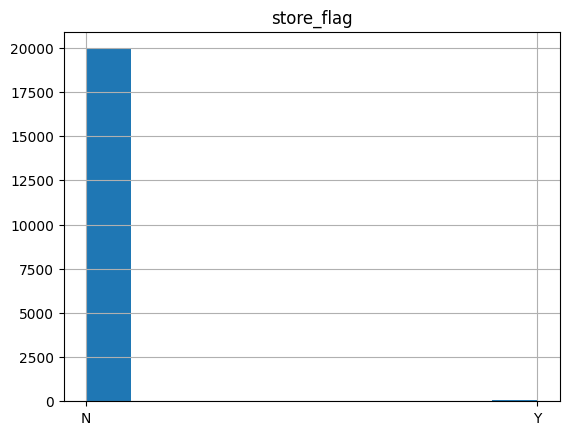

In [47]:
full_taxi_df["store_flag"].hist()
plt.title("store_flag")
plt.show()

In [48]:
len(full_taxi_df[full_taxi_df["store_flag"]=="Y"])

87

The **store_flag** column are very unbalanced. 87 of 20000 values - it's less then 0.2%. So, we cannot use this column for this data slice, and we will drop it.

In [49]:
full_taxi_df = full_taxi_df.drop(['store_flag'], axis=1)

Let's look at **vendor_id** column that has few unique values only.

In [50]:
full_taxi_df['vendor_id'].unique()

array([2, 1])

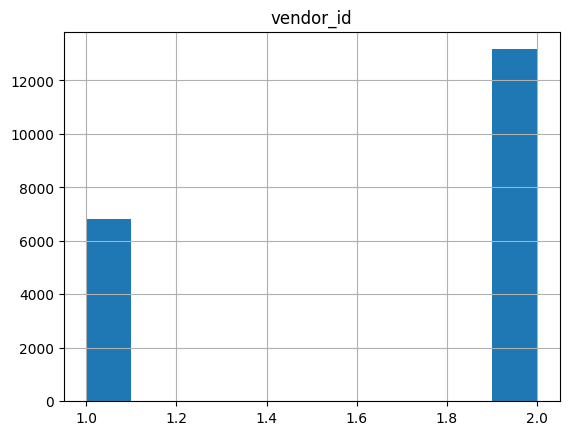

In [51]:
full_taxi_df["vendor_id"].hist()
plt.title("vendor_id")
plt.show()

The column is balanced, and we can use it. At the same time it contains two unique values only. So, we will convert it into a binary column (0, 1). 

In [52]:
full_taxi_df["vendor_id"] = np.where((full_taxi_df.vendor_id ==1), 0, 1)

Let's remove few anomalies that we mentioned above (0 position and non-positive fare).

In [53]:
full_taxi_df = full_taxi_df[(full_taxi_df['pickup_lat']>0) 
                            & (full_taxi_df['dropoff_lat']>0) 
                            & (full_taxi_df['pickup_lon']>-75)
                            & (full_taxi_df['dropoff_lon']>-75)
                            & (full_taxi_df['fare_amount']>=0)]

In [54]:
full_taxi_df.describe()

,vendor_id,passengers,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,fare_amount
count,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000,19766.000000
mean,0.660933,1.518972,2.847624,-73.954293,40.748661,-73.953946,40.748432,12.289454
std,0.473405,1.205317,3.273810,0.045097,0.045683,0.047603,0.047271,11.352945
min,0.000000,0.000000,0.000000,-74.318916,40.576401,-74.318962,40.545406,0.000000
25%,0.000000,1.000000,1.000000,-73.985596,40.721111,-73.985180,40.721192,6.500000
50%,1.000000,1.000000,1.710000,-73.963436,40.750565,-73.964413,40.751957,9.000000
75%,1.000000,1.000000,3.280000,-73.941620,40.775017,-73.939140,40.774520,14.500000
max,1.000000,6.000000,41.100000,-73.610382,40.910587,-73.386757,41.012783,499.000000


The **distance** column contains 0 as minimum - it's one more anomaly that we would like to remove.

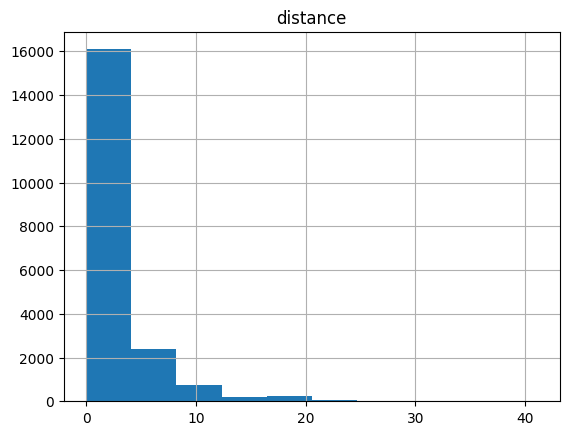

In [55]:
full_taxi_df["distance"].hist()
plt.title("distance")
plt.show()

In [56]:
full_taxi_df = full_taxi_df[full_taxi_df['distance']!=0]

In [57]:
full_taxi_df.describe()

,vendor_id,passengers,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,fare_amount
count,19597.000000,19597.000000,19597.000000,19597.000000,19597.000000,19597.000000,19597.000000,19597.000000
mean,0.660254,1.520896,2.872181,-73.954559,40.748717,-73.954209,40.748482,12.208161
std,0.473635,1.207682,3.277153,0.044737,0.045457,0.047287,0.047067,10.087562
min,0.000000,0.000000,0.010000,-74.156616,40.576401,-74.185951,40.545406,0.000000
25%,0.000000,1.000000,1.010000,-73.985657,40.721218,-73.985268,40.721390,6.500000
50%,1.000000,1.000000,1.740000,-73.963661,40.750614,-73.964752,40.752029,9.000000
75%,1.000000,1.000000,3.300000,-73.941933,40.775021,-73.939407,40.774521,14.500000
max,1.000000,6.000000,41.100000,-73.610382,40.903889,-73.386757,41.012783,299.000000


Finally, let's look at **fare_amount** distribution.

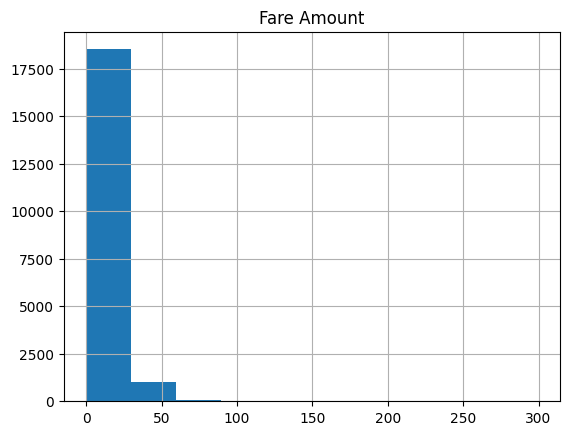

In [58]:
full_taxi_df["fare_amount"].hist()
plt.title("Fare Amount")
plt.show()

We can see that the most of the data for **fare_amount** is in [0;70] range. Let's remove everything that is less or equal 0 (I can pay 0 dollars if I have a bonus trip, but we don't need these values for fair fare prediction). 

In [60]:
full_taxi_df = full_taxi_df[(full_taxi_df['fare_amount']>0) & (full_taxi_df['fare_amount']<70)]

In [61]:
full_taxi_df.describe()

,vendor_id,passengers,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,fare_amount
count,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000
mean,0.660903,1.521715,2.848810,-73.954659,40.748703,-73.954265,40.748454,12.085086
std,0.473415,1.208854,3.200475,0.044554,0.045389,0.046595,0.046960,9.185180
min,0.000000,0.000000,0.010000,-74.156616,40.576401,-74.185951,40.545406,0.010000
25%,0.000000,1.000000,1.010000,-73.985672,40.721218,-73.985260,40.721432,6.500000
50%,1.000000,1.000000,1.730000,-73.963745,40.750614,-73.964783,40.752056,9.000000
75%,1.000000,1.000000,3.300000,-73.942024,40.775002,-73.939484,40.774502,14.500000
max,1.000000,6.000000,28.540000,-73.665794,40.903889,-73.683701,41.012783,69.500000


Everything looks nice and we have deleted less than 2% or rows only that proves our method for data cleansing.

## Step 3. Additional features generation

Let's look at the **passenger** column distribution.

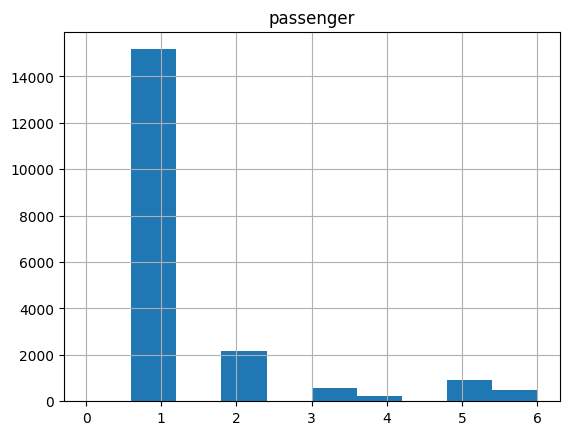

In [62]:
full_taxi_df["passengers"].hist()
plt.title("passenger")
plt.show()

The column is not balanced, and it's impossible to use a column like this. To make it more balanced, we will group data into two buckets (<=2 passangers and >2 passangers) and convert it into a binary one.

In [63]:
full_taxi_df["passengers"] = np.where((full_taxi_df.passengers <3), 0, 1)

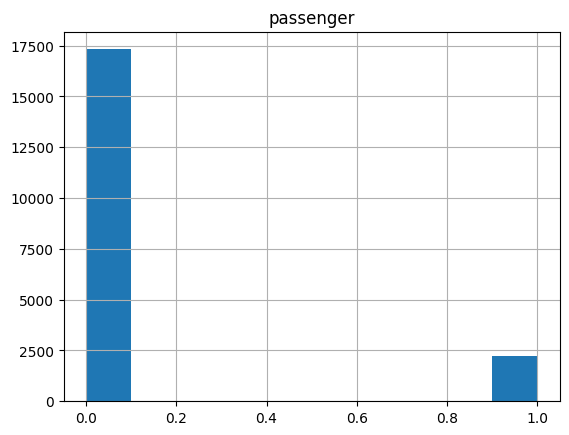

In [64]:
full_taxi_df["passengers"].hist()
plt.title("passenger")
plt.show()

Now, the column looks better. At least we should have enough data in train/test datasets.

The dataset contains two columns in **datetime64** format. We need to convert it into several columns. We don't care much about year and mounth because we have a limited slice. Additionally, it doesn't make much sense to hold seconds - it should not affect fare. So, we can concentrate our attention at **dayofweek**, **day**, **hour** and **minute**.

In [65]:
time_series = pd.DatetimeIndex(full_taxi_df["pickup_dt"], dtype="datetime64[ns]")
full_taxi_df["pickup_weekday"] = time_series.dayofweek
# full_taxi_df["pickup_month"] = time_series.month
full_taxi_df["pickup_monthday"] = time_series.day
full_taxi_df["pickup_hour"] = time_series.hour
full_taxi_df["pickup_minute"] = time_series.minute

time_series = pd.DatetimeIndex(full_taxi_df["dropoff_dt"], dtype="datetime64[ns]")
full_taxi_df["dropoff_weekday"] = time_series.dayofweek
# full_taxi_df["dropoff_month"] = time_series.month
full_taxi_df["dropoff_monthday"] = time_series.day
full_taxi_df["dropoff_hour"] = time_series.hour
full_taxi_df["dropoff_minute"] = time_series.minute

del full_taxi_df["dropoff_dt"]
del full_taxi_df["pickup_dt"]

full_taxi_df.reset_index(inplace=True, drop=True)

Let's look at the correlation matrix to see if we can delete anything else.

In [66]:
corrM = full_taxi_df.corr()

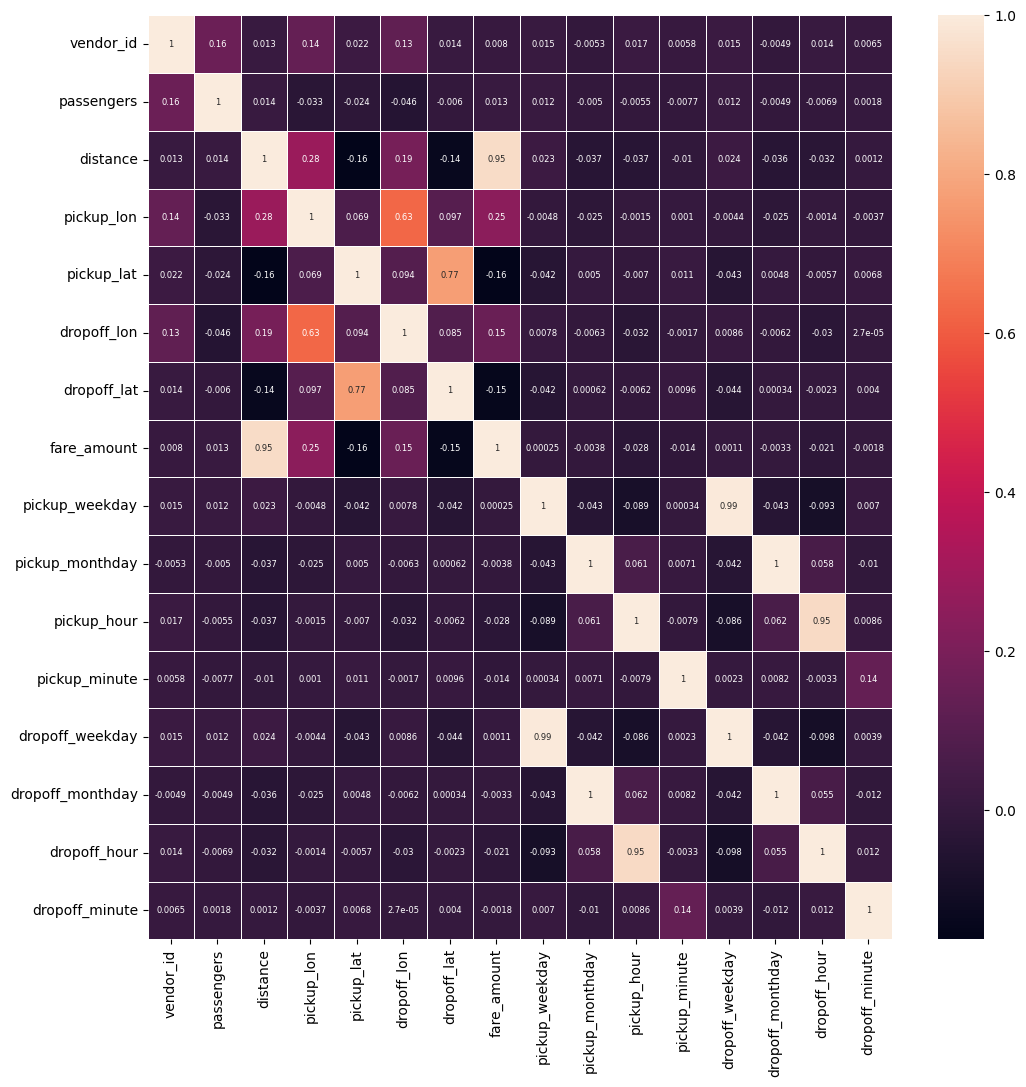

In [67]:
fig, ax = plt.subplots(figsize=(12,12)) 
ax = sns.heatmap(corrM, annot=True, linewidth=.5, ax=ax, annot_kws={"fontsize":6})

We can see that **dropoff_weekday** and **dropoff_monthday** are fully dependent on **pickup_weekday** and **pickup_monthday**. It's because we are not sitting in a taxi for days. So, we can delete two of four columns.

In [68]:
del full_taxi_df["dropoff_weekday"]
del full_taxi_df["dropoff_monthday"]

## Step 4. Building a model

It's time to train a model. Let's prepare train/test validation sets.

In [69]:
y = full_taxi_df["fare_amount"]
X = full_taxi_df.drop(['fare_amount'], axis=1)

In [70]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In the first iteration we will use all the features to train a linear regression model with no parameter regulalization as well as with parameters regularization. We are printing MSE and R2 for every model.

In [71]:
model = LinearRegression().fit(train_X, train_y)

In [72]:
predict_df = model.predict(test_X)

In [73]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 7.65
Coefficient of determination: 0.91


In [74]:
model_2 = Ridge(alpha=1.0).fit(train_X, train_y)

In [75]:
predict_df = model_2.predict(test_X)

In [76]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 7.65
Coefficient of determination: 0.91


First iteration gave us a very good R2, but we will try to see if we can get a better result using different number of features and algorithms.

Let's look at p-values for the features.

In [77]:
f_values, p_values = f_regression(train_X, train_y)

In [78]:
print(f"p-values: {p_values}")

p-values: [2.55232105e-001 1.14259987e-001 0.00000000e+000 5.71179357e-229
 1.56211371e-092 7.32686821e-085 3.02025636e-074 7.38898641e-001
 8.04104707e-001 5.51917237e-004 1.84555559e-001 1.24443122e-002
 5.12376967e-001]


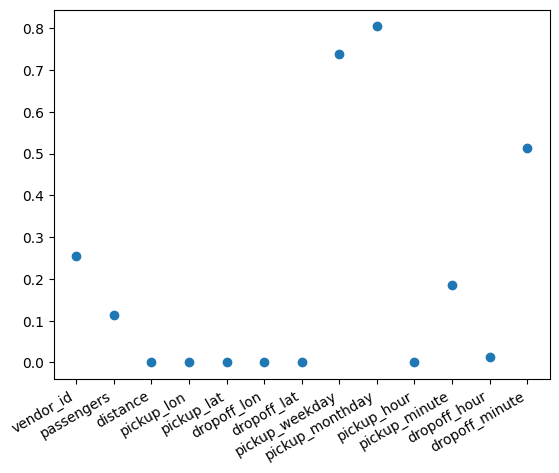

In [79]:
fig, ax = plt.subplots()

ax.scatter(train_X.columns, p_values)
plt.xticks(rotation=30, ha='right')

plt.show()

Looks like that 6 of 13 features are non-significant if we use p-value criteria.

In sklearn we can use SelectKBest to apply the creteria and get a list of features as an array

In [80]:
fs = SelectKBest(score_func=f_regression, k=7)

fs.fit(train_X, train_y)
features = fs.get_feature_names_out()
print(features)

['distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon' 'dropoff_lat'
 'pickup_hour' 'dropoff_hour']


One more algorith is based on mutual info statistic

In [104]:
fs = SelectKBest(score_func=mutual_info_regression, k=7)

fs.fit(train_X, train_y)
features = fs.get_feature_names_out()
print(features)

['passengers' 'distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon'
 'dropoff_lat' 'pickup_hour']


Both methods shows almost the same result. Use these columns.

In [82]:
columns_to_leave = ['distance', 'pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat',
                    'pickup_hour', 'pickup_minute']
train_X_f = train_X[columns_to_leave]
test_X_f = test_X[columns_to_leave]

Let's look at the linear regression again

In [83]:
model = LinearRegression().fit(train_X_f, train_y)

In [84]:
predict_df = model.predict(test_X_f)

In [85]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 7.81
Coefficient of determination: 0.91


The result looks the same. Let's look at other algorithms to see if we got the best result with the liniar regression.

In [86]:
# support vector for regression

regr = svm.SVR()
regr.fit(train_X_f, train_y)

SVR()

In [87]:
predict_df = regr.predict(test_X_f)

In [88]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 9.97
Coefficient of determination: 0.88


In [89]:
# neural net

regr = MLPRegressor(random_state=1, max_iter=500).fit(train_X_f, train_y)

In [90]:
predict_df = regr.predict(test_X_f)

In [91]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 7.15
Coefficient of determination: 0.91


In [92]:
# Decision tree for regression

clf = tree.DecisionTreeRegressor().fit(train_X_f, train_y)

In [93]:
predict_df = clf.predict(test_X_f)

In [94]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 12.62
Coefficient of determination: 0.85


In [95]:
# Gradient boosting

est = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0,loss='squared_error').fit(train_X_f, train_y)

In [96]:
predict_df = est.predict(test_X_f)

In [97]:
print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Mean squared error: 6.99
Coefficient of determination: 0.92


Gradient boosting is the best algorithm. Let's see if we can get less features to have even better R2.

In [100]:
for i in range(0, 13):
    fs = SelectKBest(score_func=f_regression, k=i+1)
    fs.fit(train_X, train_y)
    features = fs.get_feature_names_out()
    train_X_up = train_X[features]
    test_X_up = test_X[features]
    est = GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3,
        random_state=0,loss='squared_error').fit(train_X_up, train_y)
    predict_df = est.predict(test_X_up)
    print(f"Number of features {i+1}: {features}")
    print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
    print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Number of features 1: ['distance']
Mean squared error: 7.39
Coefficient of determination: 0.91
Number of features 2: ['distance' 'pickup_lon']
Mean squared error: 7.30
Coefficient of determination: 0.91
Number of features 3: ['distance' 'pickup_lon' 'pickup_lat']
Mean squared error: 7.63
Coefficient of determination: 0.91
Number of features 4: ['distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon']
Mean squared error: 7.32
Coefficient of determination: 0.91
Number of features 5: ['distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon' 'dropoff_lat']
Mean squared error: 7.29
Coefficient of determination: 0.91
Number of features 6: ['distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon' 'dropoff_lat'
 'pickup_hour']
Mean squared error: 6.94
Coefficient of determination: 0.92
Number of features 7: ['distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon' 'dropoff_lat'
 'pickup_hour' 'dropoff_hour']
Mean squared error: 6.89
Coefficient of determination: 0.92
Number of features 8: ['passengers' 'distance' 'p

If we use 8 features by p-value, we have the best MSE and R2. Let's fix 8 as a number of features and try to tune depth of the estimators.

In [107]:
fs = SelectKBest(score_func=f_regression, k=8)
fs.fit(train_X, train_y)
features = fs.get_feature_names_out()
train_X_up = train_X[features]
test_X_up = test_X[features]
    
for i in range(0, 10):
    est = GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=i+1,
        random_state=0,loss='squared_error').fit(train_X_up, train_y)
    predict_df = est.predict(test_X_up)
    print(f"Depth: {i+1}")
    print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_df))
    print("Coefficient of determination: %.2f" % r2_score(test_y, predict_df))

Depth: 1
Mean squared error: 7.22
Coefficient of determination: 0.91
Depth: 2
Mean squared error: 6.79
Coefficient of determination: 0.92
Depth: 3
Mean squared error: 6.80
Coefficient of determination: 0.92
Depth: 4
Mean squared error: 6.72
Coefficient of determination: 0.92
Depth: 5
Mean squared error: 6.66
Coefficient of determination: 0.92
Depth: 6
Mean squared error: 6.49
Coefficient of determination: 0.92
Depth: 7
Mean squared error: 6.40
Coefficient of determination: 0.92
Depth: 8
Mean squared error: 6.65
Coefficient of determination: 0.92
Depth: 9
Mean squared error: 6.81
Coefficient of determination: 0.92
Depth: 10
Mean squared error: 7.03
Coefficient of determination: 0.91


Base on the results, the best depth is 6 or 7 that has R2=0.99 and MSE = 6.4.

## Conclusion

In this project we have cleaned the dataset and picked the best model for fare amount prediction. Our model is **GradientBoostingRegressor** with depth = 7 and the following list of features: 'passengers' 'distance' 'pickup_lon' 'pickup_lat' 'dropoff_lon' 'dropoff_lat' 'pickup_hour' 'dropoff_hour'.

The result that model has produced is R2=0.92 and MSE = 6.81. It means that we can predict the fare well with an error from a real fare less than 3 dollars.